<a href="https://colab.research.google.com/github/yoshimethod/bioinformatics/blob/main/bioinformatics_pr5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
!pip install transformers sentencepiece

In [3]:
!wget https://services.healthtech.dtu.dk/services/DeepLoc-1.0/deeploc_data.fasta -P ./data -q

In [4]:
!ls ./data

deeploc_data.fasta


In [5]:
!head -n 6 ./data/deeploc_data.fasta

>Q9H400 Cell.membrane-M test
MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGSATAAEASLLRRTHLCSLSKSDTRLHELHRGPRSSRALRPASMDLLRPHWLEVSRDITGPQAAPSAFPHQELPRALPAAAATAGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPAGRSSTCGAGTPPASSCPSLGRGWRPLPASLP
>Q5I0E9 Cell.membrane-M
MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFLAQLMMFLISFISSVFCGHLGKLELDAVTLAIAVINVTGISVGHGLSSACDTLISQTYGSQNLKHVGVILQRGTLILLLCCFPCWALFINTEQILLLFRQDPDVSRLTQTYVMVFIPALPAAFLYTLQVKYLLNQGIVLPQVITGIAANLVNALANYLFLHQLHLGVMGSALANTISQFALAIFLFLYILWRKLHHATWGGWSWECLQDWASFLQLAIPSMLMLCIEWWAYEVGSFLSGILGMVELGAQSITYELAIIVYMIPAGFSVAANVRVGNALGAGNIDQAKKSSAISLIVTELFAVTFCVLLLGCKDLVGYIFTTDWDIVALVAQVVPIYAVSHLFEALACTCGGVLRGTGNQKVGAIVNAIGYYVIGLPIGISLMFVAKLGVIGLWSGIIICSVCQTSCFLVFIARLNWKLACQQAQVHANLKVNVALNSAVSQEPAHPVGPESHGEIMMTDLEKKDEIQLDQQMNQQQALPVHPKDSNKLSGKQLALRRGLLFLGVVLVLVGGILVRVYIRTE
>P63033 Cell.membrane-M
MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFEDQYTPTIEDFHRKVY

In [6]:
!wc -l ./data/deeploc_data.fasta

28008 ./data/deeploc_data.fasta


In [7]:
!pip install Bio -q
import Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.2 MB/s eta 0:00:00


In [8]:
def read_fasta(file_path, columns):
  from Bio.SeqIO.FastaIO import SimpleFastaParser
  with open(file_path) as fasta_file:
    records = []
    for title, sequence in SimpleFastaParser(fasta_file):
      record = []
      title_splits =title.split(None)
      record.append(title_splits[0])
      sequence = "".join(sequence)
      record.append(sequence)
      record.append(len(sequence))
      location_splits = title_splits[1].split("-")
      record.append(location_splits[0])
      record.append(location_splits[1])

      if(len(title_splits) > 2):
        record.append(0)
      else:
        record.append(1)

      records.append(record)
  return pd.DataFrame(records, columns = columns)

In [9]:
data = read_fasta('./data/deeploc_data.fasta', columns = ['id', 'sequence', 'sequence_length', 'location', 'membrane', 'is_train'])
data.head()

,id,sequence,sequence_length,location,membrane,is_train
0,Q9H400,MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARR...,295,Cell.membrane,M,0
1,Q5I0E9,MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...,566,Cell.membrane,M,1
2,P63033,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,266,Cell.membrane,M,1
3,Q9NR71,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,780,Cell.membrane,M,1
4,Q86XT9,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,240,Cell.membrane,M,1


In [10]:
len(data)

14004

In [11]:
data['sequence_length'].describe()

count    14004.00000
mean       522.44166
std        448.06671
min         40.00000
25%        249.00000
50%        421.00000
75%        649.00000
max      13100.00000
Name: sequence_length, dtype: float64

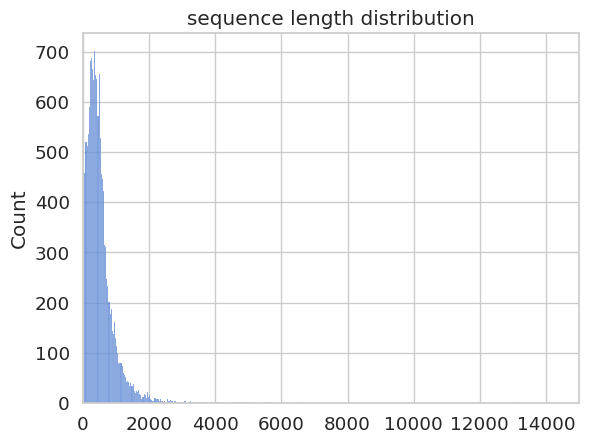

In [12]:
sns.set(style = 'whitegrid', palette = 'muted', font_scale=1.2)
ax = sns.histplot(data['sequence_length'].values)
ax.set_xlim(0, 15000)
plt.title(f'sequence length distribution')
plt.grid(True)

In [13]:
dataX = data[data['sequence_length'] < 1000]
len(dataX)

12614

In [14]:
dataX.isnull().values.any()

False

In [15]:
unique_classes = dataX.location.unique()
print('Number of classes: ', len(unique_classes))
print(unique_classes)

Number of classes:  10
['Cell.membrane' 'Cytoplasm' 'Endoplasmic.reticulum' 'Golgi.apparatus'
 'Lysosome/Vacuole' 'Mitochondrion' 'Nucleus' 'Peroxisome' 'Plastid'
 'Extracellular']


In [16]:
categories = data.location.astype('category').cat
data['location'] = categories.codes
class_names = categories.categories
num_classes = len(class_names)
print(class_names)

Index(['Cell.membrane', 'Cytoplasm', 'Endoplasmic.reticulum', 'Extracellular',
       'Golgi.apparatus', 'Lysosome/Vacuole', 'Mitochondrion', 'Nucleus',
       'Peroxisome', 'Plastid'],
      dtype='object')


In [17]:
data['location']

0        0
1        0
2        0
3        0
4        0
        ..
13999    3
14000    3
14001    3
14002    3
14003    3
Name: location, Length: 14004, dtype: int8

In [18]:
df_train = data[data.is_train == 1]
df_train = df_train.drop(['is_train'], axis = 1)
print(df_train.shape[0])
df_train.head()

11231


,id,sequence,sequence_length,location,membrane
1,Q5I0E9,MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...,566,0,M
2,P63033,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,266,0,M
3,Q9NR71,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,780,0,M
4,Q86XT9,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,240,0,M
5,A2CI98,MDPSKQGTLNRVENSVYRTAFKLRSVQTLCQLDLMDSFLIQQVLWR...,653,0,M


In [19]:
df_test = data[data.is_train == 0]
df_test = df_test.drop(['is_train'], axis = 1)
print(df_test.shape[0])
df_test.head()

2773


,id,sequence,sequence_length,location,membrane
0,Q9H400,MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARR...,295,0,M
9,P83456,AGFPEQEPEPKFWNDWAQKTLDKALSLQTLNKNKAQNLILFLGDGM...,477,0,M
15,Q9GL77,MEDEAVLDRGASFLKHVCDEEEVEGHHTIYIGVHVPKSYRRRRRHK...,1079,0,M
20,Q03445,MHSRLKFLAYLHFICASSIFWPEFSSAQQQQQTVSLTEKIPLGAIF...,991,0,M
23,P35525,MAAATAAAATVAGEGMEPRALQYEQTLMYGRYTQELGAFAKEEAAR...,907,0,M


In [20]:
from transformers import T5EncoderModel, T5Tokenizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using{}'.format(device))

Usingcpu


In [21]:
def get_T5_model():
  model = T5EncoderModel.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc')
  model = model.to(device)
  model = model.eval()
  tokenizer =T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case = False)
  return model, tokenizer

In [22]:
model, tokenizer =get_T5_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [23]:
train_sequences = {i: seq for i, seq in enumerate(df_train['sequence'])}
train_sequences

{0: 'MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFLAQLMMFLISFISSVFCGHLGKLELDAVTLAIAVINVTGISVGHGLSSACDTLISQTYGSQNLKHVGVILQRGTLILLLCCFPCWALFINTEQILLLFRQDPDVSRLTQTYVMVFIPALPAAFLYTLQVKYLLNQGIVLPQVITGIAANLVNALANYLFLHQLHLGVMGSALANTISQFALAIFLFLYILWRKLHHATWGGWSWECLQDWASFLQLAIPSMLMLCIEWWAYEVGSFLSGILGMVELGAQSITYELAIIVYMIPAGFSVAANVRVGNALGAGNIDQAKKSSAISLIVTELFAVTFCVLLLGCKDLVGYIFTTDWDIVALVAQVVPIYAVSHLFEALACTCGGVLRGTGNQKVGAIVNAIGYYVIGLPIGISLMFVAKLGVIGLWSGIIICSVCQTSCFLVFIARLNWKLACQQAQVHANLKVNVALNSAVSQEPAHPVGPESHGEIMMTDLEKKDEIQLDQQMNQQQALPVHPKDSNKLSGKQLALRRGLLFLGVVLVLVGGILVRVYIRTE',
 1: 'MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFEDQYTPTIEDFHRKVYNIHGDMYQLDILDTSGNHPFPAMRRLSILTGDVFILVFSLDSRESFDEVKRLQKQILEVKSCLKNKTKEAAELPMVICGNKNDHSELCRQVPAMEAELLVSGDENCAYFEVSAKKNTNVNEMFYVLFSMAKLPHEMSPALHHKISVQYGDAFHPRPFCMRRTKVAGAYGMVSPFARRPSVNSDLKYIKAKVLREGQARERDKCSIQ',
 2: 'MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGGHFFSTTQSPPATQGSTAAQRSTATQHSTATQSSTATQTSPVPLTPESPLFQNFSGYHIGVGRADCTGQVADINLMGYGKSGQNAQGILTRLYSRAFIMAEP

In [105]:
len(train_sequences)

11231

In [106]:
test_sequences = {i: seq.replace(' ', '') for i, seq in enumerate(df_test['sequence'])}
len(test_sequences)

2773

In [1]:
def get_embeddings(model, tokenizer, seqs, max_residues=4000, max_seq_len=1000, max_batch=100):
  results = {'protein_embs' : dict()}
  seq_dict = sorted(seqs.items(), key = lambda kv : len(seqs[kv[0]]), reverse = True)
  start = time.time()
  batch = list()
  for seq_idx, (pdb_id, seq) in enumerate(seq_dict, 1):
    seq = seq
    seq_len =len(seq)
    seq = ' '.join(list(seq))
    batch.append((pdb_id, seq, seq_len))
    n_res_batch = sum([s_len for _, _, s_len in batch]) + seq_len
    if len(batch) >= max_batch or n_res_batch >= max_residues or seq_idx == len(seq_dict) or seq_len > max_seq_len:
      pdb_ids, seqs, seq_lens =zip(*batch)
      batch = list()
      token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens = True, padding = 'longest')
      input_ids = torch.tensor(token_encoding['input_ids']).to(device)
      attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)

      try:
        with torch.no_grad():
          embedding_repr = model(input_ids, attention_mask =attention_mask)
      except RuntimeError:
        print('RuntimeError during embedding for {}(L={})'.format(pdb_id, seq_len))
        continue

      for batch_idx, identifier in enumerate(pdb_ids):
        s_len = seq_lens[batch_idx]
        emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
        protein_emb = emb.mean(dim = 0)
        results['protein_embs'][identifier] = protein_emb.detach().cpu().numpy().squeeze()

  passed_time = time.time() - start
  avg_time = passed_time/len(results['protein_embs'])
  print('\n#### EMBEDDING COMPLETED ######')
  print('Total number of per-protein embeddings: {}'.format(len(results['protein_embs'])))
  print('Time for generating embeddings: {:.1f}[m] ({:.3f}[s/protein])'.format(passed_time/60, avg_time))
  print('\n############# END #############')
  return results

In [108]:
train_embeddings = get_embeddings(model, tokenizer, train_sequences)

RuntimeError during embedding for 9697(L=13100)
RuntimeError during embedding for 2721(L=6620)
RuntimeError during embedding for 8680(L=5596)
RuntimeError during embedding for 7620(L=5560)
RuntimeError during embedding for 1636(L=5207)
RuntimeError during embedding for 9802(L=5100)
RuntimeError during embedding for 1718(L=4924)
RuntimeError during embedding for 8159(L=4910)
RuntimeError during embedding for 6901(L=4717)
RuntimeError during embedding for 8306(L=4640)
RuntimeError during embedding for 2116(L=4579)
RuntimeError during embedding for 1992(L=4196)
RuntimeError during embedding for 6697(L=4128)
RuntimeError during embedding for 2636(L=4092)
RuntimeError during embedding for 5797(L=4064)
RuntimeError during embedding for 2192(L=4024)
RuntimeError during embedding for 3067(L=4001)
RuntimeError during embedding for 7313(L=3969)
RuntimeError during embedding for 4363(L=3619)


KeyboardInterrupt: 

In [ ]:
print(train_embeddings['protein_embs'][0])
print(train_embeddings['protein_embs'][0].shape)

[-0.00218803 -0.12033813 -0.02927489 ... -0.04164226 -0.02438416
 -0.00040789]
(1024,)


In [ ]:
test_embeddings = get_embeddings(model, tokenizer, test_sequences)


#### EMBEDDING COMPLETED ######
Total number of per-protein embeddings: 2773
Time for generating embeddings: 0.5[m] (0.010[s/protein])

############# END #############


In [ ]:
train_embedding_matrices = torch.zeros(len(df_train), 1024)

for i, v in enumerate(train_embeddings['protein_embs'].values()):
  train_embedding_matrices[i] = torch.from_numpy(v.astype(np.float32))

target = torch.tensor(df_train['location'].values, dtype = torch.int64)

train_dataset = torch.utils.data.TensorDataset(train_embedding_matrices, target)

In [ ]:
batch_size = 64
train_loader =torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)

In [ ]:
class Simple_Net(nn.Module):
  def __init__(self):
    super(Simple_Net, self).__init__()
    self.fc1 = nn.Linear(1024, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.softmax(x, dim=1)
    return x

simple_net =Simple_Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_net.parameters(), lr = 0.001)

In [ ]:
loss_history = []
for epoch in range(100):
  total_loss =0
  for x, y in train_loader:
    optimizer.zero_grad()
    outputs = simple_net(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  loss_history.append(total_loss)
  print(epoch + 1, total_loss)

1 383.66697001457214
2 381.7251319885254
3 381.9229247570038
4 381.7884964942932
5 381.808176279068
6 381.897753238678
7 381.81699299812317
8 381.7461898326874
9 381.77074813842773
10 381.7759327888489
11 381.84076142311096
12 381.75317883491516
13 381.7340033054352
14 381.7375440597534
15 381.6783411502838
16 381.7199082374573
17 381.6447286605835
18 381.72510385513306
19 381.6838467121124
20 381.6686713695526
21 381.7731502056122
22 381.6718969345093
23 381.8033058643341
24 381.79840993881226
25 381.6637125015259
26 381.7219429016113
27 381.7239074707031
28 381.6414077281952
29 381.71068120002747
30 381.71164083480835
31 381.71090483665466
32 381.7237296104431
33 381.71305227279663
34 381.7151207923889
35 381.7093451023102
36 381.6609718799591
37 381.68793416023254
38 381.7192120552063
39 381.6306071281433
40 381.6478397846222
41 381.67138147354126
42 381.65449595451355
43 381.771187543869
44 381.73579454421997
45 381.6563913822174
46 381.6767840385437
47 381.66893339157104
48 381.65

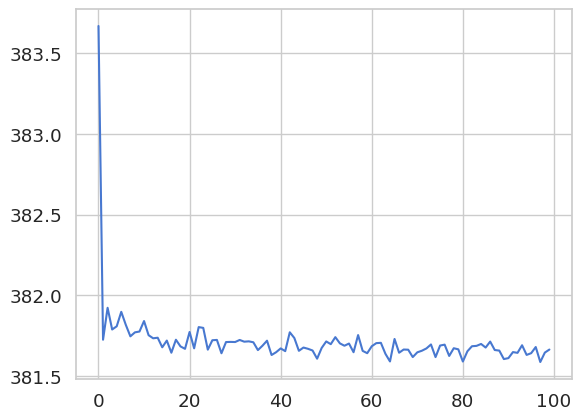

In [ ]:
plt.plot(loss_history)

In [ ]:
test_embedding_matrices = torch.zeros(len(df_test), 1024)

for i, v in enumerate(test_embeddings['protein_embs'].values()):
  test_embedding_matrices[i] = torch.from_numpy(v.astype(np.float32))

target = torch.tensor(df_test['location'].values, dtype = torch.int64)

test_dataset = torch.utils.data.TensorDataset(test_embedding_matrices, target)

In [ ]:
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for x, y in test_loader:
    outputs = simple_net(x)
    _, predicted = torch.max(outputs.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
print('正解率', int(correct)/total*100)

正解率 29.138117562206993


In [ ]:
true_list = []
pred_list = []

with torch.no_grad():
  for x, y in test_loader:
    outputs = simple_net(x)
    _, predicted = torch.max(outputs.data, 1)
    pred_list += predicted.detach().numpy().tolist()
    true_list += y.detach().numpy().tolist()

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_list, pred_list)
print(cm)

[[  0   0   0   0   0   0   0 273   0   0]
 [  0   0   0   0   0   0   0 508   0   0]
 [  0   0   0   0   0   0   0 173   0   0]
 [  0   0   0   0   0   0   0 393   0   0]
 [  0   0   0   0   0   0   0  70   0   0]
 [  0   0   0   0   0   0   0  64   0   0]
 [  0   0   0   0   0   0   0 302   0   0]
 [  0   0   0   0   0   0   0 808   0   0]
 [  0   0   0   0   0   0   0  30   0   0]
 [  0   0   0   0   0   0   0 152   0   0]]


<Axes: >

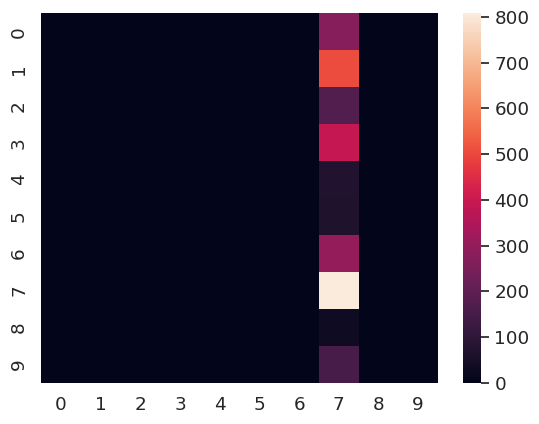

In [ ]:
sns.heatmap(cm)

アミノ酸配列のみからタンパク質局在を予測した結果


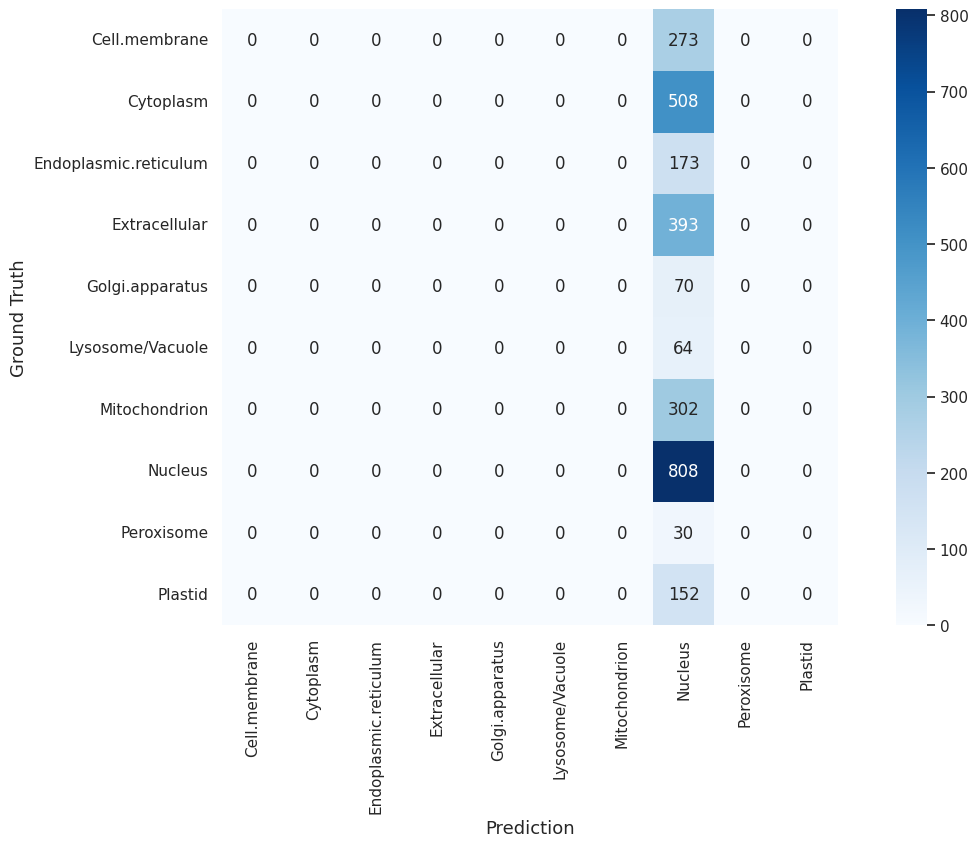

In [ ]:
cm = pd.DataFrame(data=cm, index = class_names.tolist(), columns = class_names.tolist())

sns.set(rc = {'figure.figsize':(15, 8)})
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.yticks(rotation=0)
plt.xlabel('Prediction', fontsize=13, rotation=0)
plt.ylabel('Ground Truth', fontsize=13)
ax.set_ylim(len(cm), 0)
print('アミノ酸配列のみからタンパク質局在を予測した結果')